## Get Started Object Detection

__Description__:

This notebook demonstrates how to perform object detection with DETR using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports and utility functions
2. Define the object detector
3. Prepare images for detection
4. Execute object detection
5. View detections
6. Execute simple evasion attack
7. Next Steps

## 1. Notebook imports

In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector, SUPPORTED_DETECTORS, COCO_DETR_LABELS
from heart_library.attacks.attack import JaticAttack

from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

def extract_predictions(predictions_, conf_thresh, labels=COCO_DETR_LABELS):
    # Get the predicted class
    predictions_class = [labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

## 2. Define the object detector

List the supported detectors

In [2]:
SUPPORTED_DETECTORS

{'yolov5s': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5n': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5m': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5l': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5x': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5n6': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5s6': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5m6': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5l6': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'yolov5x6': 'YOLOv5 model. Ref: https://github.com/ultralytics/yolov5',
 'fasterrcnn_resnet50_fpn': 'Faster R-CNN model. Ref:https://pytorch.org/vision/master/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2': 'Faster R-CNN model. Ref: h

In [3]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50_dc5",
                                      input_shape=(3, 800, 800),
                                      clip_values=(0, 1),
                                      attack_losses=( 
                                                     "loss_ce",
                                                     "loss_bbox",
                                                     "loss_giou",
                                                    ), 
                                      device_type="cpu",
                                      optimizer=torch.nn.CrossEntropyLoss(),
                                      preprocessing=preprocessing)

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main


## 3. Prepare images for detection

In [4]:
from datasets import load_dataset

data = load_dataset("guydada/quickstart-coco", split="train[20:25]")

preprocess = transforms.Compose([
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

## 4. Execute Object Detection

In [5]:
detections = detector(data)

## 5. View detections

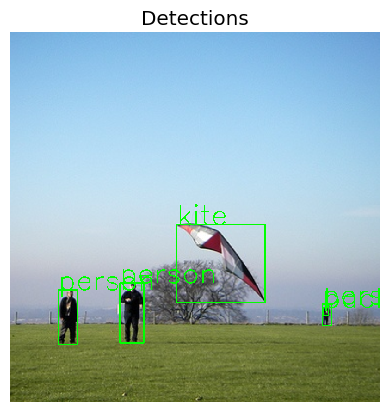

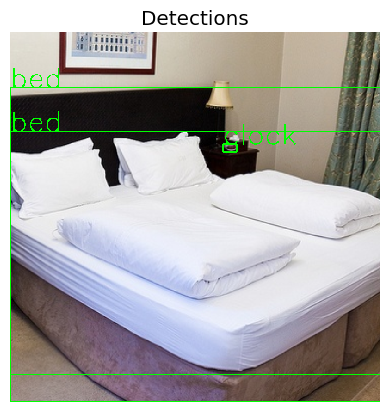

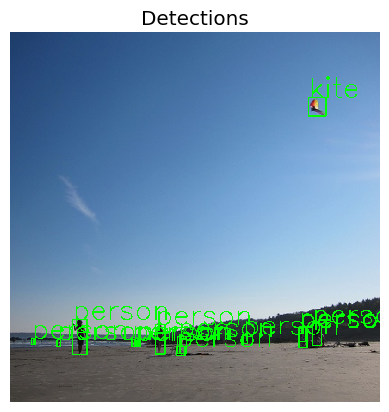

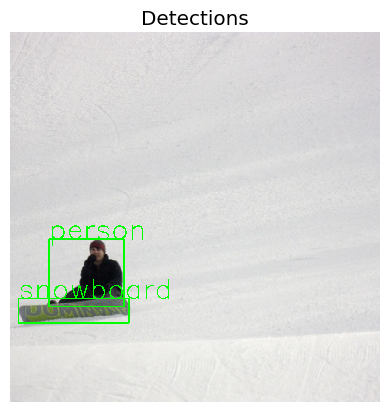

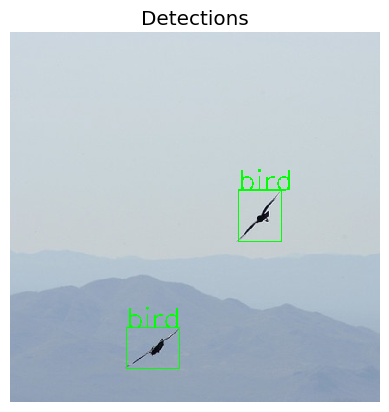

In [7]:
for i in range(len(data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 6. Execute simple evasion attack

In [8]:
from typing import Tuple, Dict, Any, Sequence
from heart_library.estimators.object_detection.pytorch import JaticPyTorchObjectDetectionOutput

class ImageDataset:
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, Sequence[JaticPyTorchObjectDetectionOutput], Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        filtered_detection = self.groundtruth[ind]
        
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

In [9]:
from copy import deepcopy

data_with_gt = ImageDataset(data, deepcopy(detections), threshold=0.5)
sample_data = torch.utils.data.Subset(data_with_gt, list(range(1)))

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=50, eps_step=0.01, eps=0.5, targeted=False,))
adv_images, _, _ = attack(sample_data)

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

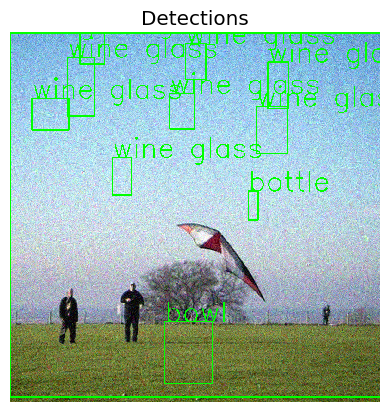

In [ ]:
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.95)
    plot_image_with_boxes(img=adv_images[0][i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

#### Targeted attack

```python
from typing import Tuple, Dict, Any
from copy import deepcopy

class TargetedImageDataset:
    def __init__(self, images, groundtruth, target_label):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.labels = [self.target_label]*len(targeted_detection.labels)
        return (image, targeted_detection, None)
    
targeted_data = TargetedImageDataset(data, deepcopy(detections), 12)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(3)))

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=50, eps_step=0.003, eps=0.03, targeted=False))
output = attack.run_attack(data)
adv_images = np.asarray(output.images)
```

## 7. Next Steps
- Swap in your own dataset and detect objects
- Apply additional adversarial attacks to the object detector (e.g. adversarial patches)